In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer, PolynomialFeatures
from sklearn.decomposition import PCA
import optuna
from optuna.samplers import TPESampler      

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

MERGE = True

<p style="text-align:center; font-size:30px; font-family:cursive;"> Welcome to PS_S3_Ep12 Challenge </p>

# Data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')
original = pd.read_csv('/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv')

# Concatenate the training and original training dataset
if MERGE:    
    total_train = pd.concat([train, original])
    total_train.drop_duplicates(inplace=True)
    total_train.drop(['id'], axis=1, inplace=True)
else:
    total_train = train

#### Let's take a look at our data and some visualization.

In [3]:
total_train

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1
...,...,...,...,...,...,...,...
74,1.025,7.90,721,23.6,301,9.04,1
75,1.017,4.81,410,13.3,195,0.58,1
76,1.024,5.40,803,21.8,394,7.82,1
77,1.016,6.81,594,21.4,255,12.20,1


#### Compared to the previous competition, there doesn't seem to be a lot of different features. 
#### If this is the case, we might have to utilize some clever feature engineering techniques to capture possible correlations within the ranks. 

In [4]:
# Define our feature and target variables
features = list(total_train.columns[:-1])
target = 'target'

## Data Visualization

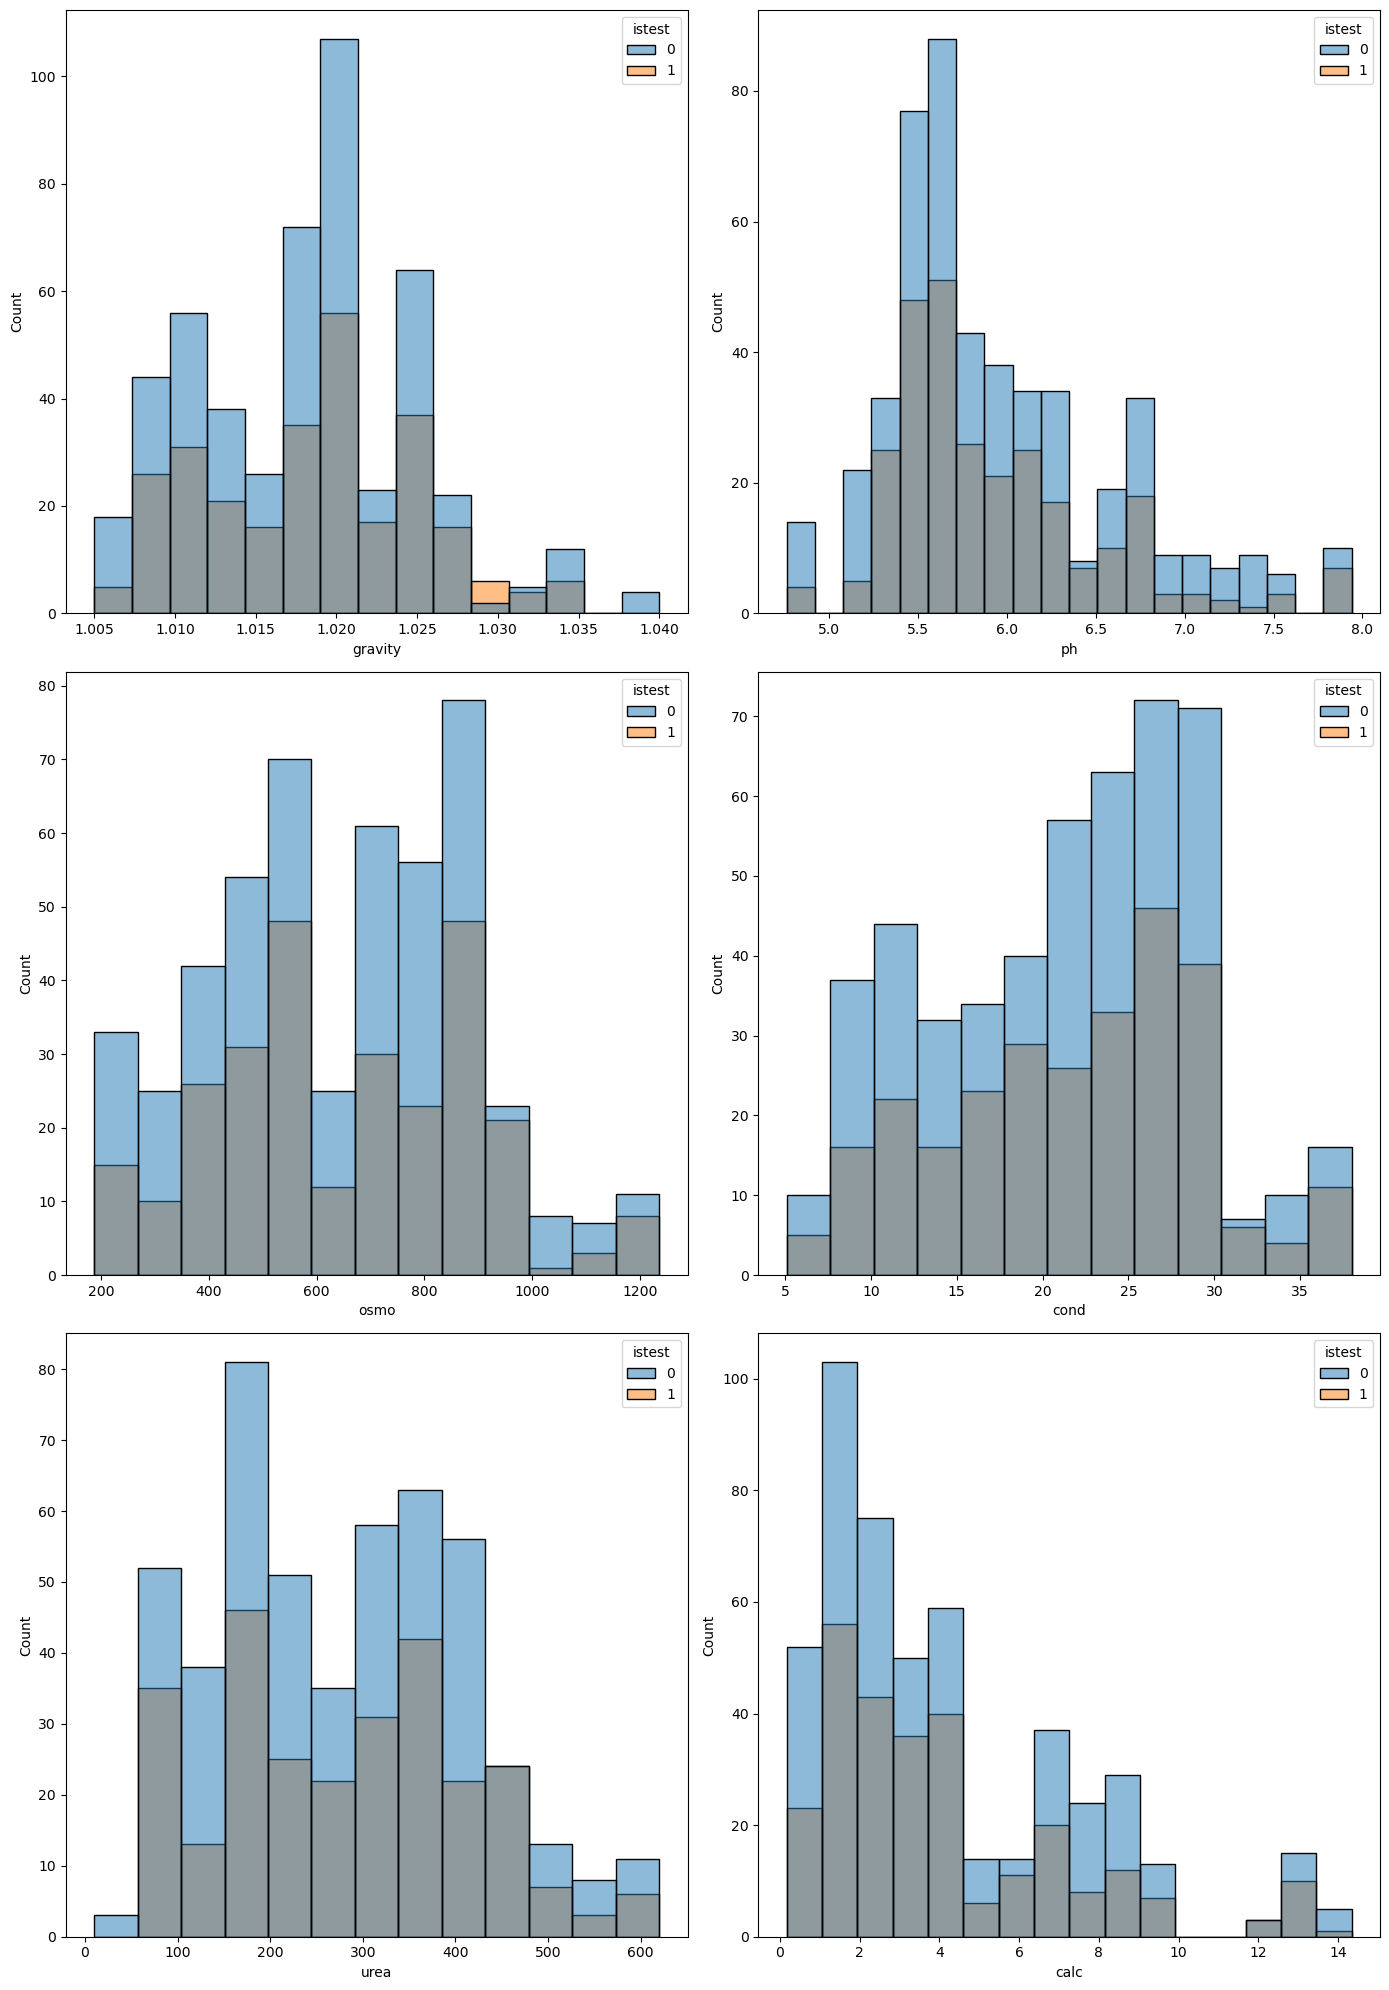

In [5]:
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(14,20))
total_train['istest'] = 0
test['istest'] = 1
features.extend(['istest'])
raw = pd.concat([total_train, test])
raw.reset_index(inplace=True)
for i in range(rows):
    for j in range(cols):
        sns.histplot(raw[features], x = features[i*2+j], hue='istest', ax=axs[i][j])
features.remove('istest')
plt.tight_layout()
plt.show()

#### As we can see some of the features like 'calc' and 'ph' is slightly skewed. 
#### I believe we can attempt to transform those. 
#### We can try to fit our models on two different datasets and observe which ones show a better score.

## Feature Engineering

#### Let's first apply some PCA to our few features.

In [6]:
pca = PCA(n_components=3)

total_train['istest'] = 0
test['istest'] = 1
raw = pd.concat([total_train,test])

raw[['pca_1', 'pca_2', 'pca_3']] = pca.fit_transform(raw[features])

total_train = raw[raw['istest'] == 0]
test = raw[raw['istest'] == 1]

if 'pca_1' not in features and 'pca_2' not in features and 'pca_3' not in features:
    features+= ['pca_1', 'pca_2', 'pca_3']

#### Let's try some feature engineering ideas too.

In [7]:
# Credits to https://www.kaggle.com/competitions/playground-series-s3e12/discussion/399441

total_train['istest'] = 0
test['istest'] = 1
raw = pd.concat([total_train,test])

# Ratio of calcium concentration to urea concentration: 
raw['calc_urea_ratio'] = raw['calc'] / raw['urea']

# Ratio of specific gravity to osmolarity: 
raw['gravity_osm_ratio'] = raw['gravity'] / raw['osmo']

# Product of calcium concentration and osmolarity: 
raw['calc_osm_product'] = raw['calc'] * raw['osmo']

# Product of specific gravity and conductivity: 
raw['gravity_cond_product'] = raw['gravity'] * raw['cond']

# Ratio of calcium concentration to specific gravity: 
raw['calc_gravity_ratio'] = raw['calc'] / raw['gravity']

# Ratio of urea concentration to specific gravity: 
raw['urea_gravity_ratio'] = raw['urea'] / raw['gravity']

# Product of osmolarity and conductivity: 
raw['osm_cond_product'] = raw['osmo'] * raw['cond']

# Ratio of calcium concentration to osmolarity: 
raw['calc_osm_ratio'] = raw['calc'] / raw['osmo']

# Ratio of urea concentration to osmolarity: 
raw['urea_osm_ratio'] = raw['urea'] / raw['osmo']

# Product of specific gravity and urea concentration: 
raw['gravity_urea_product'] = raw['gravity'] * raw['urea']

total_train = raw[raw['istest'] == 0]
test = raw[raw['istest'] == 1]

#### Now let's observe the feature correlation.

## Feature Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

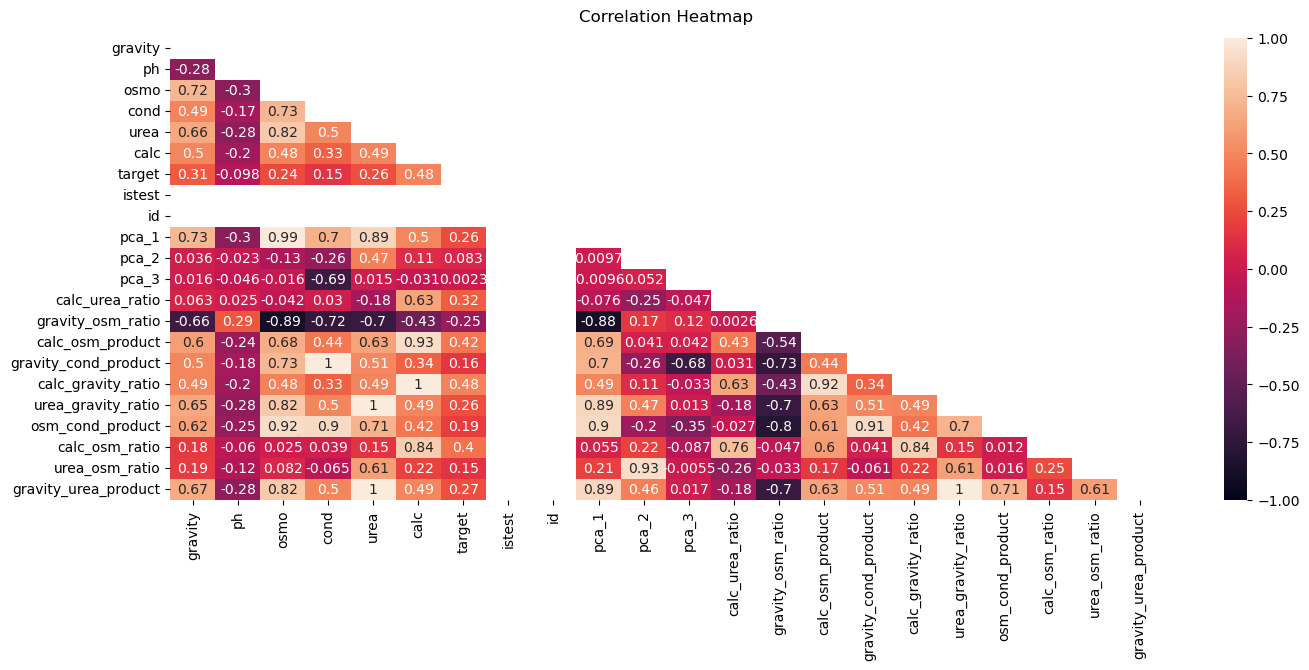

In [8]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(total_train.corr(), vmin=-1, vmax=1, annot=True, mask = np.triu(total_train.corr()))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

#### Seems like even in the given features, some of them turn out to have low correlation with our target variable and some of the engineered ones show better promise.

## Picking out features and transforming

#### Let's pick out a certain number of features that have the highest correlation with the target variable.

In [9]:
selected_features = [
    'gravity',    
    'calc',
    'pca_1'
]
print(selected_features)

['gravity', 'calc', 'pca_1']


#### Based on these features, let us make two data sets where one is only scaled and the other is scaled and transformed.

In [10]:
scaler = MinMaxScaler()
qt = QuantileTransformer()

total_train['istest'] = 0
test['istest'] = 1

# Let's concat them to prepare them for scaling
temp = pd.concat([total_train, test]).copy()
# temp[selected_features] = scaler.fit_transform(temp[selected_features])

# First dataset (scaled only)
train_scaled = temp[temp['istest'] == 0]
test_scaled = temp[temp['istest'] == 1]

temp[['calc', 'gravity']] = qt.fit_transform(temp[['calc', 'gravity']])
# Second dataset (scaled & transformed)
train_scaled_transformed = temp[temp['istest'] == 0]
test_scaled_transformed = temp[temp['istest'] == 1]

# Drop the istest column
train_scaled.drop(['istest'], axis=1, inplace=True)
test_scaled.drop(['istest'], axis=1, inplace=True)
train_scaled_transformed.drop(['istest'], axis=1, inplace=True)
test_scaled_transformed.drop(['istest'], axis=1, inplace=True)

del temp

#### Let's see what our fixed data looks like.

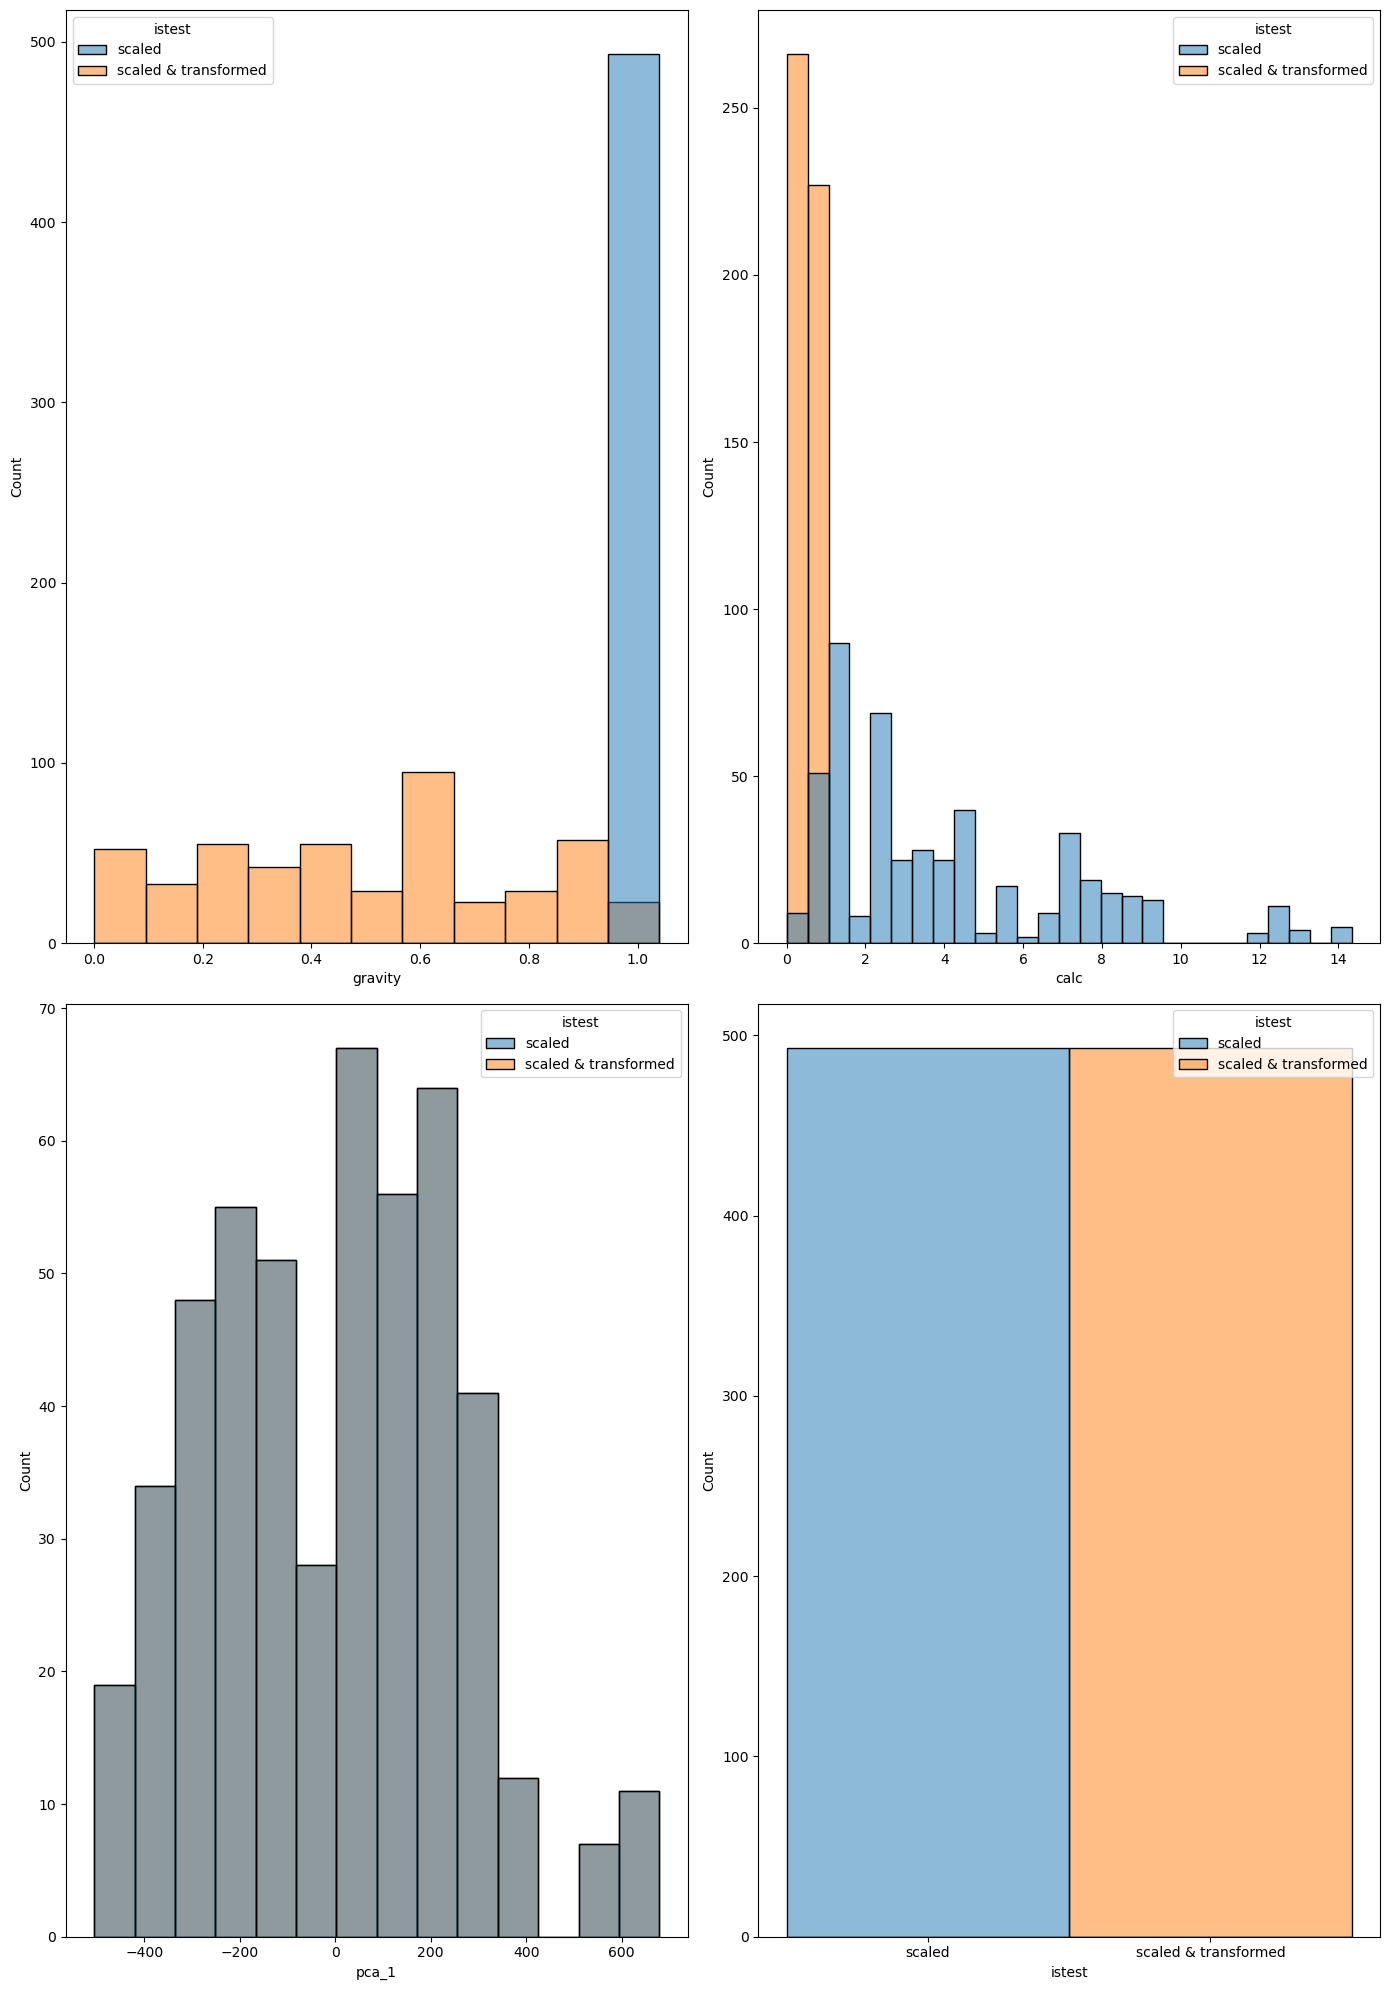

In [11]:
rows, cols = 2, 2
fig, axs = plt.subplots(rows, cols, figsize=(14,20))
train_scaled['istest'] = 'scaled'
train_scaled_transformed['istest'] = 'scaled & transformed'
selected_features.extend(['istest'])
raw = pd.concat([train_scaled, train_scaled_transformed])
raw.reset_index(inplace=True)
for i in range(rows):
    for j in range(cols):
        sns.histplot(raw[selected_features], x = selected_features[i*2+j], hue='istest', ax=axs[i][j])
selected_features.remove('istest')
plt.tight_layout()
plt.show()

#### Alright!
#### So it seems like we have scaled properly and the transformed ones show an evenly distributed data for those previously skewed data.

# Modeling

In [12]:
y = train_scaled[target]

X_scaled = train_scaled[selected_features]
X_scaled_transformed = train_scaled_transformed[selected_features]

score = {}

#### Let us explore different models.

## Logistic Regression

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
LR_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = LogisticRegression()
    model.fit(X_train, y_train)

    LR_MODELS.append( model )
    
    roc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'ROC Score:', roc_score)
    scores.append(roc_score)
    
score['lr'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
ROC Score: 0.8271656854499579
#########################
### Fold 2
#########################
ROC Score: 0.8226744186046512
#########################
### Fold 3
#########################
ROC Score: 0.742109634551495
#########################
### Fold 4
#########################
ROC Score: 0.8169133192389005
#########################
### Fold 5
#########################
ROC Score: 0.7291666666666667


Average Vaildation ROC Score: 0.7876059449023343


In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
LR_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled_transformed, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = LogisticRegression()
    model.fit(X_train, y_train)

    LR_MODELS.append( model )
    
    roc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'ROC Score:', roc_score)
    scores.append(roc_score)
    
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
ROC Score: 0.8271656854499579
#########################
### Fold 2
#########################
ROC Score: 0.8226744186046512
#########################
### Fold 3
#########################
ROC Score: 0.742109634551495
#########################
### Fold 4
#########################
ROC Score: 0.8169133192389005
#########################
### Fold 5
#########################
ROC Score: 0.7291666666666667


Average Vaildation ROC Score: 0.7876059449023343


## Decision Tree Classifier

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
decisiontree_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    decisiontree_MODELS.append( model )
    
    roc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'ROC Score:', roc_score)
    scores.append(roc_score)

score['DT'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
ROC Score: 0.6389823380992431
#########################
### Fold 2
#########################
ROC Score: 0.7335963455149501
#########################
### Fold 3
#########################
ROC Score: 0.6943521594684384
#########################
### Fold 4
#########################
ROC Score: 0.7251585623678647
#########################
### Fold 5
#########################
ROC Score: 0.60125


Average Vaildation ROC Score: 0.6786678810900992


In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
decisiontree_MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled_transformed, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    decisiontree_MODELS.append( model )
    
    roc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'ROC Score:', roc_score)
    scores.append(roc_score)
    
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
ROC Score: 0.6389823380992431
#########################
### Fold 2
#########################
ROC Score: 0.7335963455149501
#########################
### Fold 3
#########################
ROC Score: 0.6943521594684384
#########################
### Fold 4
#########################
ROC Score: 0.7251585623678647
#########################
### Fold 5
#########################
ROC Score: 0.60125


Average Vaildation ROC Score: 0.6786678810900992


## KNeighborsClassifier

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)

    MODELS.append( model )
    
    roc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'ROC Score:', roc_score)
    scores.append(roc_score)
    
score['knn'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
ROC Score: 0.7129941126997477
#########################
### Fold 2
#########################
ROC Score: 0.7842607973421927
#########################
### Fold 3
#########################
ROC Score: 0.6349667774086378
#########################
### Fold 4
#########################
ROC Score: 0.7046511627906976
#########################
### Fold 5
#########################
ROC Score: 0.6558333333333333


Average Vaildation ROC Score: 0.6985412367149217


#### The transformed data doesn't seem to show much difference from the scaled one so we shall skip it.

## RandomForestClassifier

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    MODELS.append( model )
    
    roc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'ROC Score:', roc_score)
    scores.append(roc_score)
    
score['RF'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
ROC Score: 0.7941547518923465
#########################
### Fold 2
#########################
ROC Score: 0.8039867109634552
#########################
### Fold 3
#########################
ROC Score: 0.757890365448505
#########################
### Fold 4
#########################
ROC Score: 0.8484143763213532
#########################
### Fold 5
#########################
ROC Score: 0.7375


Average Vaildation ROC Score: 0.7883892409251321


## GradientBoostingClassifier

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)

    MODELS.append( model )
    
    roc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'ROC Score:', roc_score)
    scores.append(roc_score)
    
score['GBC'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
ROC Score: 0.8328427249789739
#########################
### Fold 2
#########################
ROC Score: 0.862126245847176
#########################
### Fold 3
#########################
ROC Score: 0.7711794019933554
#########################
### Fold 4
#########################
ROC Score: 0.8522198731501056
#########################
### Fold 5
#########################
ROC Score: 0.7541666666666668


Average Vaildation ROC Score: 0.8145069825272555


## AdaBoostClassifier

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)

    MODELS.append( model )
    
    roc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'ROC Score:', roc_score)
    scores.append(roc_score)
    
score['Ada'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
ROC Score: 0.8225399495374264
#########################
### Fold 2
#########################
ROC Score: 0.81187707641196
#########################
### Fold 3
#########################
ROC Score: 0.7254983388704319
#########################
### Fold 4
#########################
ROC Score: 0.8498942917547567
#########################
### Fold 5
#########################
ROC Score: 0.7612499999999999


Average Vaildation ROC Score: 0.794211931314915


## MLPClassifier

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
MODELS = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = MLPClassifier()
    model.fit(X_train, y_train)

    MODELS.append( model )
    
    roc_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'ROC Score:', roc_score)
    scores.append(roc_score)
    
score['mlp'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
ROC Score: 0.8132884777123633
#########################
### Fold 2
#########################
ROC Score: 0.8313953488372092
#########################
### Fold 3
#########################
ROC Score: 0.7425249169435215
#########################
### Fold 4
#########################
ROC Score: 0.7915433403805497
#########################
### Fold 5
#########################
ROC Score: 0.6012500000000001


Average Vaildation ROC Score: 0.7560004167747287


## XGBClassifier

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_iteration_xgb = []
scores = []
XGB_MODELS = []

xgb_params = {
    'booster': 'gbtree',
    'objective' : 'binary:logistic',
    'eval_metric':'auc',
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 9999,
    'early_stopping_rounds': 50,
    #'tree_method':'gpu_hist',
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'random_state': 42
}

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=False)

    XGB_MODELS.append( model )
    
    ROC_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'Fold ROC Score:', ROC_score)
    scores.append(ROC_score)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = model.feature_importances_
    
    best_iteration_xgb.append(model.best_ntree_limit)
    
score['xgb'] = sum(scores)/5
print()
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
Fold ROC Score: 0.8570227081581161
#########################
### Fold 2
#########################
Fold ROC Score: 0.8351328903654485
#########################
### Fold 3
#########################
Fold ROC Score: 0.7755398671096345
#########################
### Fold 4
#########################
Fold ROC Score: 0.8862579281183933
#########################
### Fold 5
#########################
Fold ROC Score: 0.7970833333333334

Average Vaildation ROC Score: 0.8302073454169852


## LGBMClassifier

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
lgbm_MODELS = []

lgbm_params = {
    'objective' : 'binary',
    'num_iterations' : 9999,
    'learning_rate': 0.1,
    'max_depth': 4,
    'num_leaves': 500,
    'early_stopping_rounds': 50,
    #'tree_method':'gpu_hist',
    'subsample': 1,
    'colsample_bytree': 0.3,
    'random_state': 42
}

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)

    lgbm_MODELS.append( model )
    
    ROC_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'Fold ROC Score:', ROC_score)
    scores.append(ROC_score)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = model.feature_importances_
    
score['lgbm'] = sum(scores)/5
print()
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8507148864592095
#########################
### Fold 2
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8482142857142857
#########################
### Fold 3
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.804609634551495
#########################
### Fold 4
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.881183932346723
#########################
### Fold 5
#########################
[LightGBM] 

## CatBoostClassifier

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
catboost_MODELS = []

catboost_params = {
    'iterations': 9999,
    'learning_rate': 0.1,
    'depth': 10,
    'l2_leaf_reg':8 ,
    'random_strength':0.5,
    'eval_metric': 'AUC',
    #'task_type': 'GPU',
    'border_count': 128,
    'verbose': False,
    'early_stopping_rounds': 50,
    'use_best_model': True ,
    'random_state': 42,
    
}

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)

    catboost_MODELS.append( model )
    
    ROC_score = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
    print(f'Fold ROC Score:', ROC_score)
    scores.append(ROC_score)
    
score['catboost'] = sum(scores)/5
print()
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
Fold ROC Score: 0.8730025231286797
#########################
### Fold 2
#########################
Fold ROC Score: 0.8343023255813953
#########################
### Fold 3
#########################
Fold ROC Score: 0.7830149501661129
#########################
### Fold 4
#########################
Fold ROC Score: 0.8642706131078224
#########################
### Fold 5
#########################
Fold ROC Score: 0.77875

Average Vaildation ROC Score: 0.826668082396802


#### Let's see which models did the best.

## Visualization

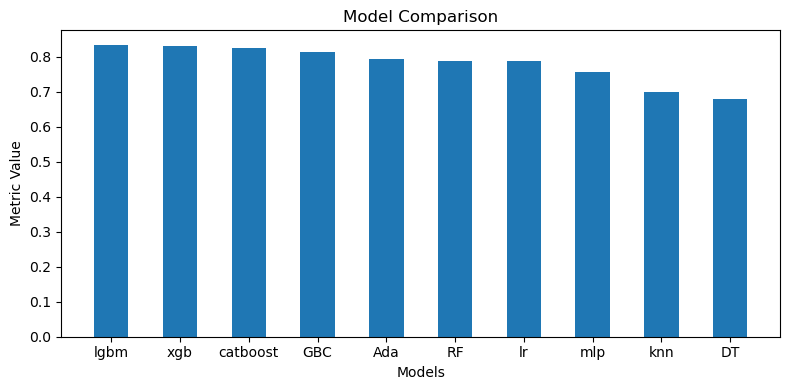

In [25]:
fig = plt.figure(figsize = (8,4))
scores = dict(sorted(score.items(), key=lambda item: -1*item[1]))
# creating the bar plot
plt.bar(scores.keys(), scores.values(), width = 0.5)
 
plt.xlabel("Models")
plt.ylabel("Metric Value")
plt.title("Model Comparison")
plt.tight_layout()
plt.show()

#### Let's see how well the ensemble of all of these models except for Decision Tree performs.

## Ensembling

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    total_score = 0
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    # Logistic Regression
    model = LogisticRegression()
    model.fit(X_train,y_train)
    lr_pred = model.predict_proba(X_valid)[:,1]
    
    # KNN
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    knn_pred = model.predict_proba(X_valid)[:,1]
    
    # Random Forest
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    rf_pred = model.predict_proba(X_valid)[:,1]
    
    # Gradient Boosting Classifier
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    gbc_pred = model.predict_proba(X_valid)[:,1]
    
    # AdaBoostClassifier
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)
    ada_pred = model.predict_proba(X_valid)[:,1]
    
    # MLP
    model = MLPClassifier()
    model.fit(X_train, y_train)
    mlp_pred = model.predict_proba(X_valid)[:,1]

    # XGB
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    xgb_pred = model.predict_proba(X_valid)[:,1]
    
    # LGBM
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    lgbm_pred = model.predict_proba(X_valid)[:,1]
    
    # CatBoost
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    catboost_pred = model.predict_proba(X_valid)[:,1]
    
    final_pred = (lr_pred + knn_pred + rf_pred + gbc_pred + ada_pred + mlp_pred + xgb_pred + lgbm_pred + catboost_pred)/9
    
    final_score = roc_auc_score(y_valid, final_pred)    
    scores.append(final_score)
    print(f'Fold ROC Score:', final_score)
    
score['e-9'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8687973086627417
#########################
### Fold 2
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8579734219269103
#########################
### Fold 3
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.768687707641196
#########################
### Fold 4
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8638477801268499
#########################
### Fold 5
#########################
[LightGBM]

#### Whao! The results are pretty impressive.
#### Let's check out other alternatives with different mixture of models.

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    total_score = 0
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    # Logistic Regression
    model = LogisticRegression()
    model.fit(X_train,y_train)
    lr_pred = model.predict_proba(X_valid)[:,1]
    
    # KNN
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    knn_pred = model.predict_proba(X_valid)[:,1]
    
    # Random Forest
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    rf_pred = model.predict_proba(X_valid)[:,1]
    
    # Gradient Boosting Classifier
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    gbc_pred = model.predict_proba(X_valid)[:,1]
    
    # MLP
    model = MLPClassifier()
    model.fit(X_train, y_train)
    mlp_pred = model.predict_proba(X_valid)[:,1]

    # XGB
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    xgb_pred = model.predict_proba(X_valid)[:,1]
    
    # LGBM
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    lgbm_pred = model.predict_proba(X_valid)[:,1]
    
    # CatBoost
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    catboost_pred = model.predict_proba(X_valid)[:,1]
    
    final_pred = (lr_pred + knn_pred + rf_pred + gbc_pred + mlp_pred + xgb_pred + lgbm_pred + catboost_pred)/8
    
    final_score = roc_auc_score(y_valid, final_pred)    
    scores.append(final_score)
    print(f'Fold ROC Score:', final_score)
    
score['e-8'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8675357443229605
#########################
### Fold 2
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8583887043189369
#########################
### Fold 3
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.771594684385382
#########################
### Fold 4
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.868076109936575
#########################
### Fold 5
#########################
[LightGBM] 

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    total_score = 0
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    # Logistic Regression
    model = LogisticRegression()
    model.fit(X_train,y_train)
    lr_pred = model.predict_proba(X_valid)[:,1]
    
    # Random Forest
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    rf_pred = model.predict_proba(X_valid)[:,1]
    
    # Gradient Boosting Classifier
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    gbc_pred = model.predict_proba(X_valid)[:,1]
    
    # MLP
    model = MLPClassifier()
    model.fit(X_train, y_train)
    mlp_pred = model.predict_proba(X_valid)[:,1]

    # XGB
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    xgb_pred = model.predict_proba(X_valid)[:,1]
    
    # LGBM
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    lgbm_pred = model.predict_proba(X_valid)[:,1]
    
    # CatBoost
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    catboost_pred = model.predict_proba(X_valid)[:,1]
    
    final_pred = (lr_pred + rf_pred + gbc_pred + mlp_pred + xgb_pred + lgbm_pred + catboost_pred)/7
    
    final_score = roc_auc_score(y_valid, final_pred)    
    scores.append(final_score)
    print(f'Fold ROC Score:', final_score)
    
score['e-7'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8679562657695542
#########################
### Fold 2
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8363787375415281
#########################
### Fold 3
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.7736710963455149
#########################
### Fold 4
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8591966173361523
#########################
### Fold 5
#########################
[LightGBM

In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    total_score = 0
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    # Logistic Regression
    model = LogisticRegression()
    model.fit(X_train,y_train)
    lr_pred = model.predict_proba(X_valid)[:,1]
    
    # Gradient Boosting Classifier
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    gbc_pred = model.predict_proba(X_valid)[:,1]
    
    # MLP
    model = MLPClassifier()
    model.fit(X_train, y_train)
    mlp_pred = model.predict_proba(X_valid)[:,1]

    # XGB
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=False)
    xgb_pred = model.predict_proba(X_valid)[:,1]
    
    # LGBM
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    lgbm_pred = model.predict_proba(X_valid)[:,1]
    
    # CatBoost
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    catboost_pred = model.predict_proba(X_valid)[:,1]
    
    final_pred = (lr_pred + gbc_pred + mlp_pred + xgb_pred + lgbm_pred + catboost_pred)/6
    
    final_score = roc_auc_score(y_valid, final_pred)    
    scores.append(final_score)
    print(f'Fold ROC Score:', final_score)
    
score['e-6'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8738435660218672
#########################
### Fold 2
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8504983388704319
#########################
### Fold 3
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.7774086378737541
#########################
### Fold 4
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.86553911205074
#########################
### Fold 5
#########################
[LightGBM] 

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    total_score = 0
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    # Logistic Regression
    model = LogisticRegression()
    model.fit(X_train,y_train)
    lr_pred = model.predict_proba(X_valid)[:,1]
    
    # MLP
    model = MLPClassifier()
    model.fit(X_train, y_train)
    mlp_pred = model.predict_proba(X_valid)[:,1]

    # XGB
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    xgb_pred = model.predict_proba(X_valid)[:,1]
    
    # LGBM
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    lgbm_pred = model.predict_proba(X_valid)[:,1]
    
    # CatBoost
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    catboost_pred = model.predict_proba(X_valid)[:,1]
    
    final_pred = (lr_pred + mlp_pred + xgb_pred + lgbm_pred + catboost_pred)/5
    
    final_score = roc_auc_score(y_valid, final_pred)    
    scores.append(final_score)
    print(f'Fold ROC Score:', final_score)
    
score['e-5'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8687973086627419
#########################
### Fold 2
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8463455149501662
#########################
### Fold 3
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.7865448504983389
#########################
### Fold 4
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.866384778012685
#########################
### Fold 5
#########################
[LightGBM]

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    total_score = 0
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    # Logistic Regression
    model = LogisticRegression()
    model.fit(X_train,y_train)
    lr_pred = model.predict_proba(X_valid)[:,1]

    # XGB
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    xgb_pred = model.predict_proba(X_valid)[:,1]
    
    # LGBM
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    lgbm_pred = model.predict_proba(X_valid)[:,1]
    
    # CatBoost
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    catboost_pred = model.predict_proba(X_valid)[:,1]
    
    final_pred = (lr_pred + xgb_pred + lgbm_pred + catboost_pred)/4
    
    final_score = roc_auc_score(y_valid, final_pred)    
    scores.append(final_score)
    print(f'Fold ROC Score:', final_score)
    
score['e-4'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8717409587888982
#########################
### Fold 2
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8438538205980066
#########################
### Fold 3
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.7852990033222592
#########################
### Fold 4
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8761099365750529
#########################
### Fold 5
#########################
[LightGBM

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    total_score = 0
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]

    # XGB
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    xgb_pred = model.predict_proba(X_valid)[:,1]
    
    # LGBM
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    lgbm_pred = model.predict_proba(X_valid)[:,1]
    
    # CatBoost
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    catboost_pred = model.predict_proba(X_valid)[:,1]
    
    final_pred = (xgb_pred + lgbm_pred + catboost_pred)/3
    
    final_score = roc_auc_score(y_valid, final_pred)    
    scores.append(final_score)
    print(f'Fold ROC Score:', final_score)
    
score['e-3'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)
    
score['e-3'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8725820016820859
#########################
### Fold 2
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.841362126245847
#########################
### Fold 3
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.7875830564784054
#########################
### Fold 4
#########################
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Fold ROC Score: 0.8816067653276956
#########################
### Fold 5
#########################
[LightGBM]

In [33]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    total_score = 0
    
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]

    # XGB
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    xgb_pred = model.predict_proba(X_valid)[:,1]
    
    # CatBoost
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)
    catboost_pred = model.predict_proba(X_valid)[:,1]
    
    final_pred = (xgb_pred + catboost_pred)/2
    
    final_score = roc_auc_score(y_valid, final_pred)    
    scores.append(final_score)
    print(f'Fold ROC Score:', final_score)
    
score['e-2'] = sum(scores)/5
print('\n')
print(f'Average Vaildation ROC Score:', sum(scores)/5)

#########################
### Fold 1
#########################
Fold ROC Score: 0.8784693019343986
#########################
### Fold 2
#########################
Fold ROC Score: 0.8384551495016611
#########################
### Fold 3
#########################
Fold ROC Score: 0.7693106312292358
#########################
### Fold 4
#########################
Fold ROC Score: 0.8744186046511627
#########################
### Fold 5
#########################
Fold ROC Score: 0.7966666666666666


Average Vaildation ROC Score: 0.831464070796625


#### Let's observe the results for all the combination of the ensemble with the previous models.

## Visualization

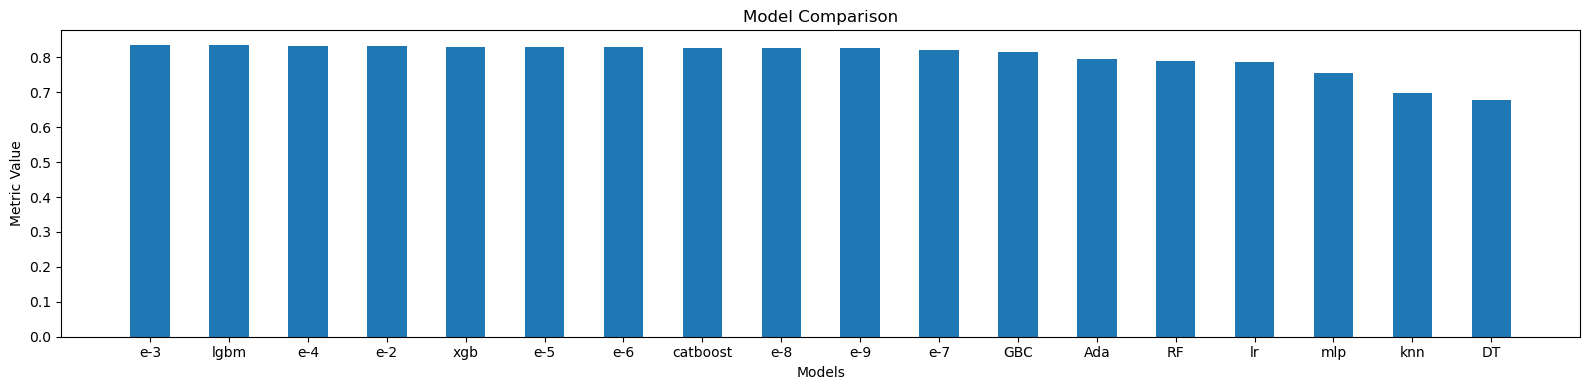

In [34]:
fig = plt.figure(figsize = (16,4))
scores = dict(sorted(score.items(), key=lambda item: -1*item[1]))
# creating the bar plot
plt.bar(scores.keys(), scores.values(), width = 0.5)
 
plt.xlabel("Models")
plt.ylabel("Metric Value")
plt.title("Model Comparison")
plt.tight_layout()
plt.show()

#### Seems like XGBClassifier still outperformed all the other models.
#### As always, XGBClassifier always impresses me. 

# Submission

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

XGB_MODELS = []
for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)

    XGB_MODELS.append( model )
    
CATBOOST_MODELS = []
for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)

    CATBOOST_MODELS.append( model )
    
LR = LogisticRegression().fit(X_scaled,y)
GBC = GradientBoostingClassifier().fit(X_scaled,y)
mlp = MLPClassifier().fit(X_scaled,y)
    
LGBM_MODELS = []
for i, (train_index, valid_index) in enumerate(kf.split(X_scaled, y)):
    
    X_train = X_scaled.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_valid = X_scaled.iloc[valid_index]
    y_valid = y.iloc[valid_index]
    
    model = LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             verbose=0)

    LGBM_MODELS.append( model )
    

test = test_scaled
submission = pd.DataFrame(index = test.index.unique())
submission['id'] = test.id.unique()

for i in range(5):
    submission[f'XGB_cost{i}'] = XGB_MODELS[i].predict_proba(test[selected_features])[:,1]
    submission[f'CATBOOST_cost{i}'] = CATBOOST_MODELS[i].predict_proba(test[selected_features])[:,1]
    submission[f'LR_cost{i}'] = LR.predict_proba(test[selected_features])[:,1]
    submission[f'GBC_cost{i}'] = GBC.predict_proba(test[selected_features])[:,1]
    submission[f'MLP_cost{i}'] = mlp.predict_proba(test[selected_features])[:,1]
    submission[f'LGBM_cost{i}'] = LGBM_MODELS[i].predict_proba(test[selected_features])[:,1]
    
submission['XGB'] = (submission.XGB_cost0 + submission.XGB_cost1 + submission.XGB_cost2 + submission.XGB_cost3 + submission.XGB_cost4) / 5
submission['CATBOOST'] = (submission.CATBOOST_cost0 + submission.CATBOOST_cost1 + submission.CATBOOST_cost2 + submission.CATBOOST_cost3 + submission.CATBOOST_cost4) / 5
submission['LR'] = (submission.LR_cost0 + submission.LR_cost1 + submission.LR_cost2 + submission.LR_cost3 + submission.LR_cost4) / 5
submission['LGBM'] = (submission.LGBM_cost0 + submission.LGBM_cost1 + submission.LGBM_cost2 + submission.LGBM_cost3 + submission.LGBM_cost4) / 5
submission['GBC'] = (submission.GBC_cost0 + submission.GBC_cost1 + submission.GBC_cost2 + submission.GBC_cost3 + submission.GBC_cost4) / 5
submission['MLP'] = (submission.MLP_cost0 + submission.MLP_cost1 + submission.MLP_cost2 + submission.MLP_cost3 + submission.MLP_cost4) / 5

submission['pred'] = (submission['XGB'] + submission['CATBOOST'] + submission['LR'])/3
submission = submission[['id','pred']]
submission.to_csv('submission.csv', index=False)

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
